In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pickle.load(open('clean_dataset_2022/train_set.bin', 'rb'))

test_data = pickle.load(open('clean_dataset_2022/test_set.bin', 'rb'))

## SARIMAX

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Resample

In [4]:
province = ['BKK','CNX','KKC','RAY','SARA','SURAT']

In [5]:
for p in province:
    train_data[p] = train_data[p].resample('6H').mean()

    tmp_df = test_data[p].copy()
    tmp_df['PM25'] = test_data[p]['PM25'].asfreq(freq='6H')
    test_data[p] = test_data[p].resample('6H').mean()
    test_data[p]['PM25'] = tmp_df['PM25']

### Split 70% 30%

In [6]:
train_set = {} ; valid_set = {} ; test_set = test_data

ratio = 0.7

for p in province:
    train_size, valid_size = int(ratio*train_data[p].shape[0]), int((1-ratio)*train_data[p].shape[0])
    train_set[p], valid_set[p] = train_data[p].iloc[:train_size], train_data[p].iloc[train_size: ]

### Training 6 provinces with *minimal_SARIMAX*

In [7]:
from importlib import reload

In [8]:
from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

##### Tuning Parameters

In [9]:
order = [(2, 0, 0), (2, 1, 0), (2, 1, 0), (2, 1, 0), (1, 0, 1), (2, 0, 0)]
seasonal_order = [(1, 0, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 0, 0, 1461), (0, 1, 0, 1461)]

exog_order = {}
exog_order['Temp'] = [(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 0)]
exog_order['WindSpeed'] = [(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0)]
exog_order['WindDir'] = [(1, 1, 0), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1)]

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = [(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 1, 1461), (0, 1, 0, 1461), (0, 1, 1, 1461)]
exog_seasonal_order['WindSpeed'] = [(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 1, 1, 1461)]
exog_seasonal_order['WindDir'] = [(1, 1, 0, 1461), (0, 1, 0, 1461), (1, 0, 0, 1461), (1, 1, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461)]

exog_columns = ['Temp', 'WindSpeed', 'WindDir']

In [10]:
model = {}
model_exog = {}

for i, p in enumerate(province):
    model[p] = MinimalSARIMAX(train_data[p][['PM25']],
                order[i],
                seasonal_order[i],
                exog=train_data[p][exog_columns])
    
    model_exog[p] = {}    
    for exog in exog_columns:
        model_exog[p][exog] = MinimalSARIMAX(train_data[p][[exog]],
                                            exog_order[exog][i],
                                            exog_seasonal_order[exog][i])

In [11]:
for p in province:
    model[p].fit(lr=1e-5, lr_decay=0.999 ,verbose=0)

In [12]:
for p in province:
    for exog in exog_columns:
        if exog == 'WindDir':
            model_exog[p][exog].fit(lr=5e-7, lr_decay=0.999, verbose=0)
        else:
            model_exog[p][exog].fit(lr=1e-5, lr_decay=0.999, verbose=0)

In [13]:
Result = {}
train_pred_sav = {}
test_pred_sav = {}
Error_save = {}

#### Bangkok

In [14]:
Result['BKK'] = model['BKK'].predict_step(train_data['BKK'][['PM25']],
                                    test_data['BKK'][['PM25']], 
                                    val_X_exog=train_data['BKK'][exog_columns],
                                    y_exog=test_data['BKK'][exog_columns], 
                                    model_exog=model_exog['BKK'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['BKK'], test_pred_sav['BKK'], Error_save['BKK'] = Result['BKK']

100%|██████████| 5847/5847 [15:41<00:00,  6.21it/s]


In [ ]:
with open('model_save/model_bkk.model',"wb") as f:
    pickle.dump(model['BKK'], f)

In [15]:
predict = test_pred_sav['BKK'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['BKK'], test_pred_sav['BKK']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

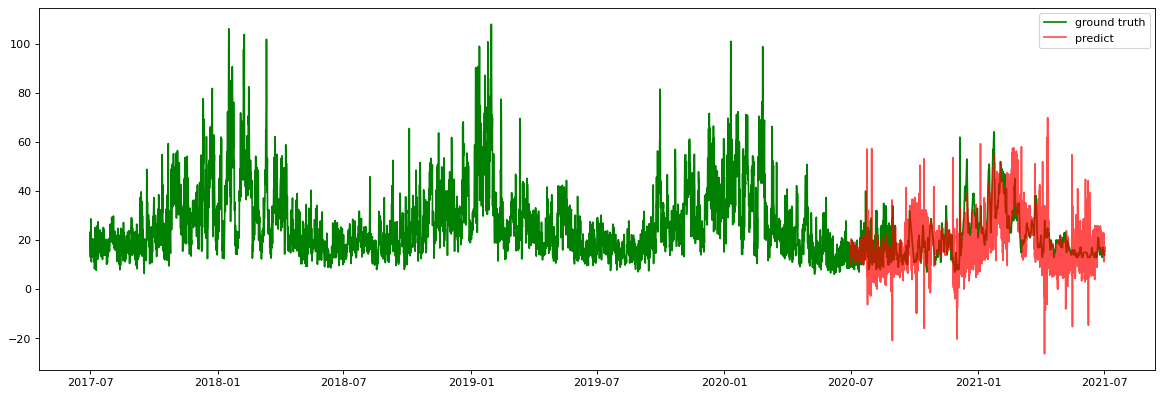

In [16]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['BKK'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_BKK.csv')

#### Chiangmai

In [ ]:
Result['CNX'] = model['CNX'].predict_step(train_data['CNX'][['PM25']],
                                    test_data['CNX'][['PM25']], 
                                    val_X_exog=train_data['CNX'][exog_columns],
                                    y_exog=test_data['CNX'][exog_columns], 
                                    model_exog=model_exog['CNX'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['CNX'], test_pred_sav['CNX'], Error_save['CNX'] = Result['CNX']

In [ ]:
with open('model_save/model_cnx.model',"wb") as f:
    pickle.dump(model['CNX'], f)

In [ ]:
predict = test_pred_sav['CNX'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['CNX'],test_pred_sav['CNX']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

In [ ]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['CNX'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_CNX.csv')

#### Khonkaen

In [ ]:
Result['KKC'] = model['KKC'].predict_step(train_data['KKC'][['PM25']],
                                    test_data['KKC'][['PM25']], 
                                    val_X_exog=train_data['KKC'][exog_columns],
                                    y_exog=test_data['KKC'][exog_columns], 
                                    model_exog=model_exog['KKC'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['KKC'], test_pred_sav['KKC'], Error_save['KKC'] = Result['KKC']

In [ ]:
with open('model_save/model_kkc.model',"wb") as f:
    pickle.dump(model['KKC'], f)

In [ ]:
predict = test_pred_sav['KKC'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['KKC'],test_pred_sav['KKC']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

In [ ]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['KKC'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_KKC.csv')

#### Rayong

In [ ]:
Result['RAY'] = model['RAY'].predict_step(train_data['RAY'][['PM25']],
                                    test_data['RAY'][['PM25']], 
                                    val_X_exog=train_data['RAY'][exog_columns],
                                    y_exog=test_data['RAY'][exog_columns], 
                                    model_exog=model_exog['RAY'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['RAY'], test_pred_sav['RAY'], Error_save['RAY'] = Result['RAY']

In [ ]:
with open('model_save/model_ray.model',"wb") as f:
    pickle.dump(model['RAY'], f)

In [ ]:
predict = test_pred_sav['RAY'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['RAY'],test_pred_sav['RAY']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

In [ ]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['RAY'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_RAY.csv')

#### Saraburi

In [ ]:
Result['SARA'] = model['SARA'].predict_step(train_data['SARA'][['PM25']],
                                    test_data['SARA'][['PM25']], 
                                    val_X_exog=train_data['SARA'][exog_columns],
                                    y_exog=test_data['SARA'][exog_columns], 
                                    model_exog=model_exog['SARA'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['SARA'], test_pred_sav['SARA'], Error_save['SARA'] = Result['SARA']

In [ ]:
with open('model_save/model_sara.model',"wb") as f:
    pickle.dump(model['SARA'], f)

In [149]:
predict = test_pred_sav['SARA'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['SARA'],test_pred_sav['SARA']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

In [150]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['SARA'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_SARA.csv')

#### Surat

In [ ]:
Result['SURAT'] = model['SURAT'].predict_step(train_data['SURAT'][['PM25']],
                                    test_data['SURAT'][['PM25']], 
                                    val_X_exog=train_data['SURAT'][exog_columns],
                                    y_exog=test_data['SURAT'][exog_columns], 
                                    model_exog=model_exog['SURAT'],
                                    lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=True)

train_pred_sav['SURAT'], test_pred_sav['SURAT'], Error_save['SURAT'] = Result['SURAT']

In [ ]:
with open('model_save/model_sara.model',"wb") as f:
    pickle.dump(model['SURAT'], f)

In [ ]:
predict = test_pred_sav['SURAT'].sort_values(by=['Time'])

X = pd.concat([train_pred_sav['SURAT'],test_pred_sav['SURAT']]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])
Acu = X.sort_values(by=['Time'])

In [ ]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'], X_time['Actual'], color='g', label='ground truth')
plt.plot(predict['Time'], predict['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
test_pred_sav['SURAT'].drop(columns=['t','s']).to_csv('answer_dataset/pred_and_actual/y_pred_sav_SURAT.csv')